In [29]:
import binascii
import numpy as np
import matplotlib.pyplot as plt

# Sincronización

En el receptor que calcula el promedio deslizante, se suponía que conocíamos los límites de tiempo de cada pulso

En la práctica la señal viene precedida por una cantidad indeterminada de ceros ruidosos

* Se necesita algo para saber en qué instantes empezamos a tomar las muestras del promedio deslizante

* Se necesita algo para saber cuando empieza la transmisión

## Determinación del instante óptimo de muestreo

* Realizaremos el promediado deslizante

* Descomponemos la señal filtrada en bloques de tamaño D empezando por la primera muestra

* Formaremos una matriz de (nmues/D) x D

In [30]:
transmitidar=np.load('transmitidar.npy')

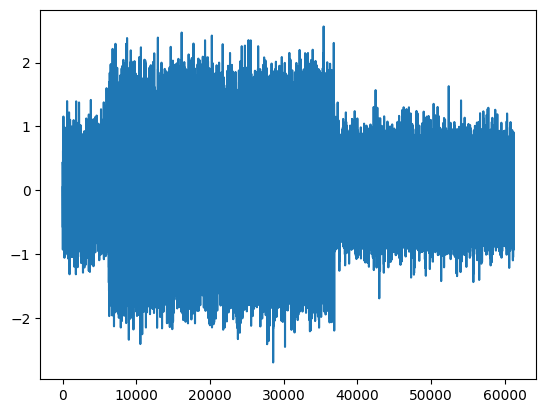

In [31]:
_=plt.plot(transmitidar)

In [32]:
D=25
h=np.ones(D)/D
prom_deslizante=np.convolve(transmitidar,h,'same')
bloques=[]
n1=0
n2=n1+D

while n2 <= len(prom_deslizante):
    bloque=prom_deslizante[n1:n2]
    n1 +=D
    n2 +=D
    bloques.append(bloque)
bloques=np.array(bloques)

(2448, 25)


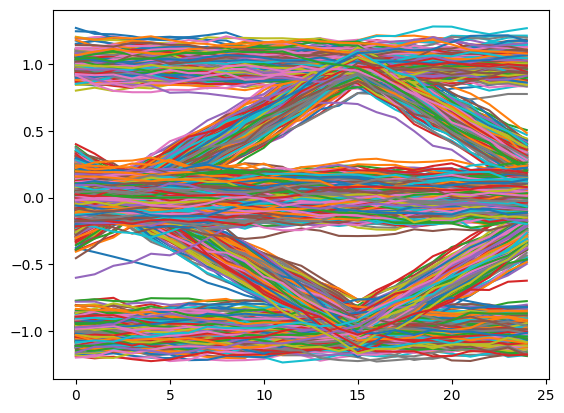

In [55]:
print(bloques.shape)
# Diagrama de ojos
#_=plt.plot(bloques[400:1200,:].T)
_=plt.plot(bloques.T)

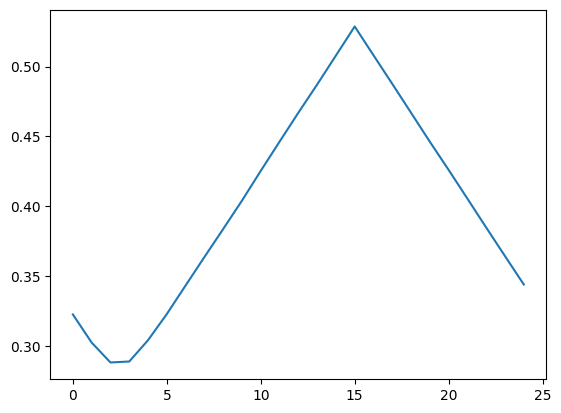

In [34]:
suma=np.mean(np.abs(bloques),axis=0)
_=plt.plot(suma)

In [35]:
posicion=np.argmax(suma)
print(posicion)
posicion2=(np.argmin(suma)+D//2) % D
print(posicion2)

15
14


In [36]:
amplt_recibidas=prom_deslizante[posicion::D]

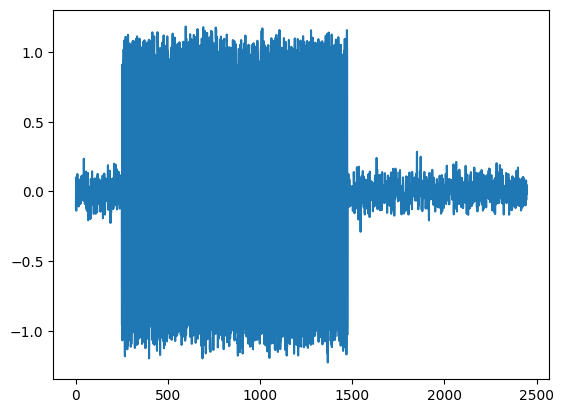

In [37]:
_=plt.plot(amplt_recibidas)

## Determinando donde está el primer bit

Se puede hacer de dos maneras
* Buscando donde tenemos amplitudes suficientemente grandes

* Buscando alguna secuencia de bits "especial" (Hello Google)

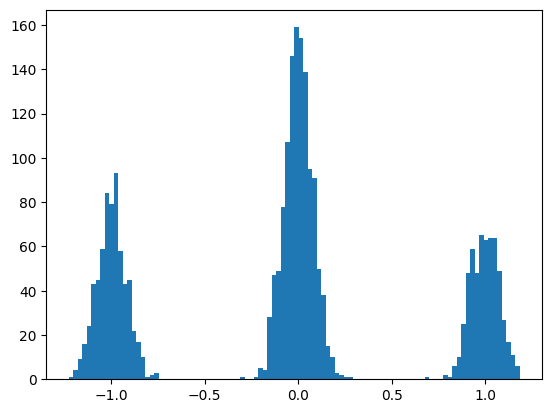

In [38]:
_=plt.hist(amplt_recibidas,bins=100)

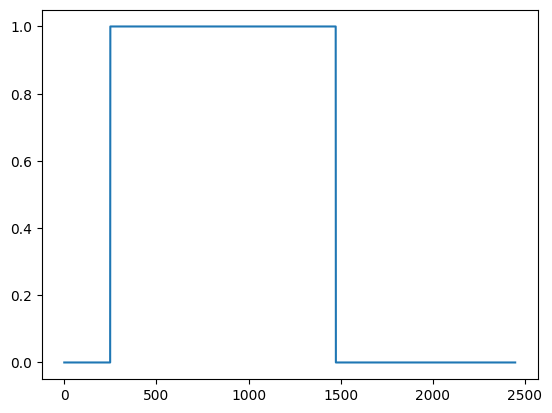

In [39]:
# Ponemos un umbral para el valor absoluto de 0.5

validos=(np.abs(amplt_recibidas)>0.5)
_=plt.plot(validos)

In [40]:
# Parece que son los bits
amplt_recibidas_trx=amplt_recibidas[validos]
print(len(amplt_recibidas_trx))

1224


In [41]:
bits_recibidos=(amplt_recibidas_trx>0)
bits=np.load('bits.npy')
Prob_error=np.mean(bits_recibidos != bits)
print('Prob error:',Prob_error)

Prob error: 0.0


### Determinación del inicio y el fin mediante la búsqueda de un patrón de bits

Normalmente, los bits se empaquetan en **tramas**

Las tramas tienen unas **cabeceras** que son una secuencia de bits que indica donde empieza un bloque de información

En nuestro caso supondremos conocidos los primeros 32 bits que se transmiten y los últimos

In [42]:
cabecera_inicio=bits[:32]
cabecera_fin=bits[-32:]

bits_recibidos=(amplt_recibidas>0)

In [43]:
primer_bit=None
ultimo_bit=None

n1=0
n2=n1+32 # Cantidad de bits de cabecera

# Primero buscamos el primer bit util
while n2 <= len(bits_recibidos):
    bloque=bits_recibidos[n1:n2].astype(np.int16)
    diferencia = np.sum(np.abs(bloque-cabecera_inicio))
    if diferencia==0:
        primer_bit = n1
        break
    n1 +=1
    n2+=1

#Ahora el ultimo exclusive
while n2 <= len(bits_recibidos):
    bloque=bits_recibidos[n1:n2].astype(np.int16)
    diferencia = np.sum(np.abs(bloque-cabecera_fin))
    if diferencia==0:
        ultimo_bit = n2
        break
    n1 +=1
    n2+=1    
        
        


In [44]:
primer_bit,ultimo_bit

(250, 1474)

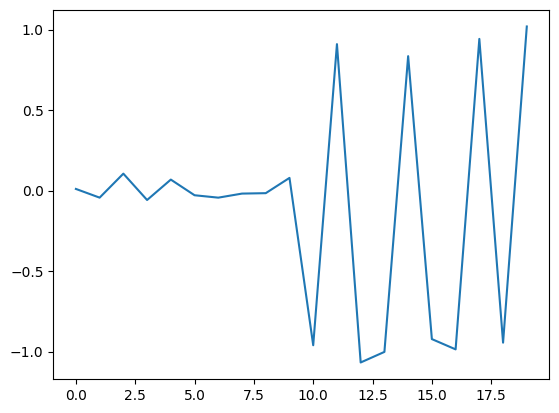

In [54]:
_=plt.plot(amplt_recibidas[primer_bit-10:primer_bit+10])

In [45]:
bits_recibidos_utiles=bits_recibidos[primer_bit:ultimo_bit]
print(len(bits_recibidos_utiles))
bits=np.load('bits.npy')
Prob_error=np.mean(bits_recibidos_utiles != bits)
print('Prob error:',Prob_error)

1224
Prob error: 0.0


## Falta por hacer

* Agrupar los bits en bytes, formando grupos de 8

* Interpretar cada grupo de 8 bits como un byte y obtener el carácter correspondiente

In [46]:
grupos=[]
n1=0
n2=n1+8
while n2 <= len(bits_recibidos_utiles):
    grupos.append(bits_recibidos_utiles[n1:n2])
    n1+=8
    n2+=8

In [47]:
len(grupos)

153

In [48]:
grupos[0]

array([False,  True, False, False,  True, False, False,  True])

In [49]:
def boolarray_2_bit_string(array):
    cadena=""
    for e in array:
        if e:
            cadena +="1"
        else:
            cadena +="0"
    return cadena

In [50]:
boolarray_2_bit_string(grupos[1])

'01001110'

In [51]:
tabla={}
letras="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,;:-_=+ */&%#?!"
for l in letras:
    codigo='{0:08b}'.format(ord(l))
    tabla[codigo]=l

In [52]:
def decodificar(bits):
    tabla={}
    texto=""
    letras="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,;:-_=+ */&%#?!"
    for l in letras:
        codigo='{0:08b}'.format(ord(l))
        tabla[codigo]=l
    n1=0
    n2=n1+8
    grupos=[]
    while n2 <= len(bits):
        grupos.append(bits[n1:n2])
        n1+=8
        n2+=8
        
    for elemento in grupos:
        codigo=boolarray_2_bit_string(elemento)
        if codigo in tabla:
            texto += tabla[codigo]
        else:
            texto+="··"
    return texto
        

In [53]:
TEXTO_RECUPERADO=decodificar(bits_recibidos_utiles)
print("TEXTO RECUPERADO:")
print(TEXTO_RECUPERADO)

TEXTO RECUPERADO:
INICIOEsto es un texto de prueba que convertiremos en bits, luego en una forma de onda, para posteriormente detectar los bits, y recomponer el mensajeFIN
